# SVM Model with Pipeline

#### Importing libraries and loading data

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

#### Establishing input and output columns

In [13]:
X = df.drop('energy', axis=1)
y = df['energy']


#### Splitting data into training and testing sets

In [14]:
from sklearn.model_selection import train_test_split


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=56)

#### Creating the pipeline

Previously I was using the ColumnTransformer to create a preprocessing pipeline to apply different scaling techniques to the columns. However,  I switched to using the Pipeline class to create a pipeline that applies the preprocessing steps and the model. This is because the ColumnTransformer does not allow for the use of the GridSearchCV, RandomSearchCV, or BayesSearchCV class to tune the hyperparameters of the model.

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

# This is the preprocessing pipeline: SVMs need scaling
scaler = StandardScaler()
# We use gausian / radial kernel
svc = SVC(random_state=56, kernel="rbf")

# This is the preprocessing pipeline: SVMs need scaling
pipe_scale_svc = Pipeline([
    ('scale', scaler),
    ('SVM', svc)])



# RandomizedSearchCV

Instead of trying out all possible combinations of hyperparameters, as GridSearchCV does, RandomizedSearchCV samples a fixed number of hyperparameter settings from specified probability distributions. This can be more efficient, especially when searching over a large hyperparameter space. 
- For cross validation, data will be split using K-Fold cross-validation with 3 folds.
- The budget sets the number of parameter settings to sample, which in this case is set to 20.

In [28]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import loguniform
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


param_grid_rand = {
    'SVM__C': loguniform(1e-1, 1e4),
    'SVM__gamma': loguniform(1e-4, 1e0),
}

inner = KFold(n_splits=3, shuffle=True, random_state=56)

budget = 20

hpo_pipe_scale_svc_rand = RandomizedSearchCV(pipe_scale_svc, param_grid_rand, n_iter=budget, cv=inner, scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, random_state=56)

hpo_pipe_scale_svc_rand.fit(X_train, y_train)

print(f"Best parameters set found on development set: {hpo_pipe_scale_svc_rand.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters set found on development set: {'SVM__C': 1482.8210739371198, 'SVM__gamma': 0.000242575212089949}


In order to evaluate the model, I am checking the mean absolute error and the r squared score. The mean absolute error is the average of the absolute value of the errors between the predicted and actual values. The r squared score is the proportion of the variance in the dependent variable that is predictable from the independent variable. Because our date is bimodally skewed, I am using mean absolute error as the primary metric to evaluate the model.

In [29]:
# Evaluate the model
mae_rand = mean_absolute_error(y_test, hpo_pipe_scale_svc_rand.predict (X=X_test))
print (f'Mean Squared Error: {mae_rand}')
r2_rand = r2_score(y_test, hpo_pipe_scale_svc_rand.predict (X=X_test))
print(f'R^2 Score: {r2_rand}')

Mean Squared Error: 2996859.189041096
R^2 Score: 0.6887793450388799


# Bayesian Optimization (BayesSearchCV)

Bayesian optimization builds a probabilistic model of the objective function (performance metric) and uses this model to decide the next set of hyperparameters to evaluate. It considers both the information gained from the model and the uncertainty associated with different hyperparameter settings. We chose his approach because it is more sample-efficient than grid and random search because it intelligently selects points in the hyperparameter space to sample, focusing on promising regions.

In [25]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real

# search space 
param_grid = {'SVM__C': Real(1e-1, 1e4, prior="log-uniform"),
              'SVM__gamma': Real(1e-3, 1e0, prior="log-uniform")}

inner = KFold(n_splits=3, shuffle=True, random_state=56)

budget = 20

hpo_pipe_scale_svc = BayesSearchCV(pipe_scale_svc, param_grid, n_iter=budget, cv=inner, scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, random_state=56)
hpo_pipe_scale_svc.fit(X_train, y_train)

print(f"Best parameters set found on development set: {hpo_pipe_scale_svc.best_params_}")



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [26]:
# Evaluate the model
mae = mean_absolute_error(y_test, hpo_pipe_scale_svc.predict (X=X_test))
print (f'Mean Squared Error: {mae}')
r2 = r2_score(y_test, hpo_pipe_scale_svc.predict (X=X_test))
print(f'R^2 Score: {r2}')

Mean Squared Error: 2983421.4246575343
R^2 Score: 0.6905137441403761


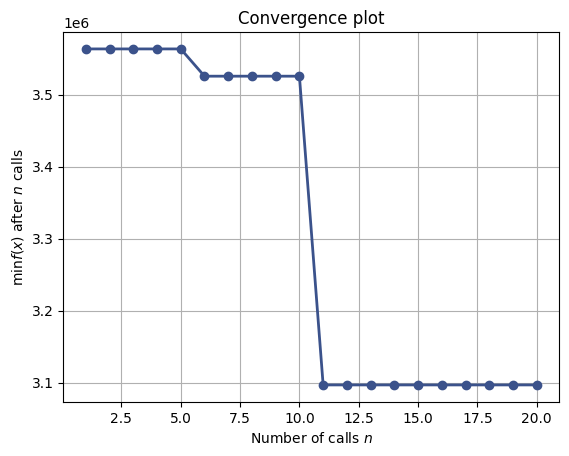

In [27]:
from skopt.plots import plot_convergence

_ = plot_convergence(hpo_pipe_scale_svc.optimizer_results_[0])
plt.show()